Importing the necessary libraries and packages

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Defining the function that the neural network needs to learn

In [ ]:
def func(x):
  y = 2*x**3 + 4*x**2 + 3*x**4 + 7*x**6
  return y

Forming a class to generate datasets as its objects

In [ ]:
#data generating class
#generating random floating point numbers with a mean = 0, and standard deviation = 1

class data_gen():

  #initialising the class
  def __init__(self,n):
    super().__init__()
    #using np.random.randn to generate a normalised list of floating point random numbers of length n
    x1 = np.random.randn(n)
    #converting it to a PyTorch tensor of appropriate rank
    x2 = torch.from_numpy(x1)
    x = x2.view(n, 1)
    self.x = x.to(dtype = torch.float32)

    self.size = len(x1)

    #passing x through the function func() to generate y 
    y1 = np.array([float(func(i)) for i in list(self.x.flatten().numpy())])
    #generating the mean and standard deviation of the theoretical results
    self.mean_y = np.mean(y1)
    self.std_y = np.std(y1)
    #normalising the theoretical results to a standard normal distribution
    #conveting it to a PyTorch tensor of appropriate rank and data type
    y2 = torch.from_numpy(np.array([((i - self.mean_y)/(self.std_y)) for i in y1]))
    y2 = y2.to(torch.float32)
    self.y = y2.view(n, 1)

  #returning the mean and standard deviation for subsequent use
  def return_stat(self):
    return self.mean_y, self.std_y

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    return self.x[idx].float(), self.y[idx].float()

Randomly splitting the dataset indices into training, validation and test sets

In [ ]:
#the function takes the total size, validation percentage and test percentage as inputs

def split_val(size, val_pct, test_pct):
  n_val = int(size*val_pct)
  n_test = int(size*test_pct)
  #introducing more randomness in the dataset
  index = np.random.permutation(size)
  #splitting the index array into the training, validation and test sets using slicing operations
  return(index[(n_val + n_test):], index[n_val:(n_val + n_test)], index[:n_val])

\Initialising the training set and returning the training and validation indices as NumPy arrays

In [ ]:
#defining size of the dataset
n = 5000
#forming the dataset from the data generating class
data_set = data_gen(n)
#obtaining the training and validation indices
train_idx, val_idx, test_idx = split_val(n, val_pct = 0.2, test_pct = 0.2)
#storing the mean and standard deviation of the theoretical results for the whole dataset
mean_y, std_y = data_set.return_stat()
print(mean_y, std_y)


print(len(val_idx))

120.62876853953604 692.1278853383033
1000


Defining the batchsize for the dataset and forming separate PyTorch DataLoaders for training, vaidation and testing after randomly sampling with respect to the previously obtained training, validation and testing indices respectively

In [ ]:
#creating PyTorch DataLoaders for training and validation

#defining the data batch size
batchsize = 20

#randomly sampling the data for training using the previously defined training indices
sample_train = SubsetRandomSampler(train_idx)
#forming the training DataLoader
train_dl = DataLoader(data_set, batchsize, sampler = sample_train)

#randomly sampling the data for validation using the previously defined validation indices
sample_val = SubsetRandomSampler(val_idx)
#forming the training DataLoader
valid_dl = DataLoader(data_set, batchsize, sampler = sample_val)

sample_test = SubsetRandomSampler(test_idx)
#forming the test DataLoader
test_dl = DataLoader(data_set, batch_size = 10, sampler = sample_test)

Initialising the neural network parameters. Since we will be going with a simple feedforward neural network, we use PyTorch's torch.nn.Sequential to describe a basic multi-layer network. The model parameter shapes (weights and biases), and the total number of model parameters are also printed for clarity

In [ ]:
input_size = 1
hidden_size = 512
output_size = 1

model = nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, output_size),
)


#checking model parameters
print('Model architecture:\n')
for t in model.parameters():
  print(t.shape)

#displaying the total number of model parameters
total_params = sum(t.numel() for t in model.parameters())
print('\ntotal number of parameters in the model = %d'%total_params)

Model architecture:

torch.Size([512, 1])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([1, 512])
torch.Size([1])

total number of parameters in the model = 264193


In [ ]:
def default_device():
  #Selects GPU if it is available, otherwise CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


def to_device(t, device):
  #Moves the tensor t to the chosen device
  #the data can be a tensor or a list/tuple of tensors

  if isinstance(t, (list,tuple)):
    return [to_device(i,device) for i in t]
  return t.to(device, non_blocking = True)


class DeviceDataLoader():
  #moving data to the device only when that batch is called
  #This is done instead of the whole batch so that the large dataset does not waste GPU memory

  def __init__(self, dl,device):
    super().__init__()
    self.dl = dl
    self.device = device

  def __iter__(self):
    #yields a batch of data after transferring it to the device
    for i in self.dl:
      yield to_device(i, self.device)

  def __len__(self):
    #number of batches
    return len(self.dl)


In [ ]:
device = default_device()
if (device == torch.device('cuda')):
  print('CUDA Available')
  print('Using GPU')

else:
  print('Using CPU')

Using CPU


In [ ]:
for x,y in train_dl:
    print(x[0].shape)
    break

torch.Size([1])


In [ ]:
#moving the training and validation dataloaders to validation device

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

to_device(model, device)

Sequential(
  (0): Linear(in_features=1, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

the loss_batch function is defined which calculates the loss for a particular batch with respect to the provided loss function. If the optimiser is provided, this function conducts the backward propagation for the model parameters and updates them based on the learning rate for each iteration. The loss, and length of the data are returned


In [ ]:
def loss_batch(model, loss_fn, x, y, opt = None):

  #for a given optimiser function:
  if opt is not None:
    # get the inputs; data is a list of [inputs, labels]
    # zero the parameter gradients
    opt.zero_grad()
    # forward + backward + optimize
    preds = model(x)
    loss = loss_fn(preds, y)
    loss.backward()
    opt.step()

  else: 
    preds = model(x)
    loss = loss_fn(preds, y)

  return loss.item(), len(x)

The evaluate function is defined which calculates the average loss of the validation dataset per epoch, while training the model.

In [ ]:
def evaluate(model, loss_fn, valid_dl, opt = None):
    
  #evaluating each batch through the model
  for x,y in valid_dl:
    loss,counts = loss_batch(model, loss_fn, x, y, opt)

  #total size of the dataset
  size = np.sum(counts)

  #calculating the average loss
  #avg_loss = np.sum(np.multiply(loss,counts))/size
  avg_loss = np.average(loss)
  #returning average loss, total size
  return avg_loss, size

Checking the initial test and validation loss before training

In [ ]:
init_val_loss,_ = evaluate(model, F.mse_loss, valid_dl)
init_train_loss,_ = evaluate(model, F.mse_loss, train_dl)

print('Initial validation loss:', init_val_loss)
print('Initial training loss:', init_train_loss)


Initial validation loss: 0.03986233472824097
Initial training loss: 0.10104306787252426


The fit function runs for a specified number of epochs. it defines the loss function (MSE loss in this case). The optimizer is loaded with the model parameters and provided learning rate. The model trains over the training dataloader and calls the loss_batch function, and then subsequently is evaluated over the validation dataloader by calling the evaluate function to calculate the average validation loss for each epoch.

In [ ]:
def fit(epochs,lr, model, train_dl, valid_dl, opt_fn = None):

  loss_fn = F.mse_loss
  if opt_fn == None:
    opt_fn = torch.optim.SGD
  opt = opt_fn(model.parameters(), lr=lr)

  train_losses = []
  val_losses = []

  loss1 = []

  for epoch in range(epochs):  # loop over the dataset multiple times
    model.train()
    

    train_loss,_ = evaluate(model, loss_fn, train_dl, opt)

      
    model.eval()
    val_loss,_ = evaluate(model,loss_fn,valid_dl)
    #train_loss,_ = evaluate(model,loss_fn,train_dl)

    #saving the losses for each epoch as a list
    val_losses.append(val_loss)
    train_losses.append(train_loss)


    # printing the validation loss for each 50 epochs
    if epoch%1 == 0:
      print('Epoch [{}/{}], Training Loss: {:.8f}, Validation Loss: {:.8f}'.format(epoch+1,epochs, train_loss, val_loss))

  print('Finished Training')

  print('\nFinal training loss = ', train_losses[-1])
  print('Final validation loss = ', val_losses[-1])

  #returning the list containing the losses
  return train_losses, val_losses

Setting the number of epochs, learning rate and the optimizer function and calling the fit function which begins training the model

In [ ]:
import torch
FILE = '/content/drive/MyDrive/Neural Network Models/poly_predict_model.pth'
model = torch.load(FILE, map_location=torch.device('cpu'))

In [ ]:
epochs = 200
learning_rate = 3e-4

train_losses, val_losses = fit(epochs,learning_rate,model,train_dl,valid_dl, opt_fn = torch.optim.SGD)
epochs_list = [i+1 for i in range(epochs)]

Epoch [1/200], Training Loss: 0.00000418, Validation Loss: 0.00000270
Epoch [2/200], Training Loss: 0.00000486, Validation Loss: 0.00000635
Epoch [3/200], Training Loss: 0.00001370, Validation Loss: 0.00000514
Epoch [4/200], Training Loss: 0.00000171, Validation Loss: 0.00000195
Epoch [5/200], Training Loss: 0.00000360, Validation Loss: 0.00000348
Epoch [6/200], Training Loss: 0.00121095, Validation Loss: 0.00000304
Epoch [7/200], Training Loss: 0.00500595, Validation Loss: 0.00001566
Epoch [8/200], Training Loss: 0.00000054, Validation Loss: 0.00001913
Epoch [9/200], Training Loss: 0.00000337, Validation Loss: 0.00000244
Epoch [10/200], Training Loss: 0.00000401, Validation Loss: 0.00000955
Epoch [11/200], Training Loss: 0.06953731, Validation Loss: 0.00058163
Epoch [12/200], Training Loss: 0.00000083, Validation Loss: 0.00000103
Epoch [13/200], Training Loss: 0.00000169, Validation Loss: 0.00000126
Epoch [14/200], Training Loss: 0.00027767, Validation Loss: 0.00001124
Epoch [15/200],

KeyboardInterrupt: ignored

PLotting the value of validation loss against epoch to show the decrease of the loss with increasing epochs.

In [ ]:
init_val_loss,_ = evaluate(model, F.mse_loss, valid_dl)
init_train_loss,_ = evaluate(model, F.mse_loss, train_dl)

print('Initial validation loss:', init_val_loss)
print('Initial training loss:', init_train_loss)


Initial validation loss: 1.2452457667677663e-05
Initial training loss: 0.0010704040760174394


In [ ]:
'''print('\nPlotting the decrease in validation loss with increasing number of epochs\n')
plt.figure(figsize = (8,5))
plt.plot(epochs_list, val_losses, color = 'darkblue', label = 'Loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()'''

"print('\nPlotting the decrease in validation loss with increasing number of epochs\n')\nplt.figure(figsize = (8,5))\nplt.plot(epochs_list, val_losses, color = 'darkblue', label = 'Loss')\nplt.title('Validation loss')\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.grid()\nplt.legend()\nplt.show()"

In [ ]:
'''FILE = '/content/drive/MyDrive/Neural Network Models/poly_predict_model.pth'
torch.save(model, FILE)'''

In [ ]:
import torch
FILE = '/content/drive/MyDrive/Neural Network Models/poly_predict_model.pth'
model = torch.load(FILE, map_location=torch.device('cpu'))

To test the model on unseen data, we use the test dataloader that we formed in the beginning. For data in this dataloader, we call the trained model to predict the results. Now, since the results were normalised during training, the predicted results are un-normalised using the mean and standard deviation used initially, and then the results are plotted to show the model reliability

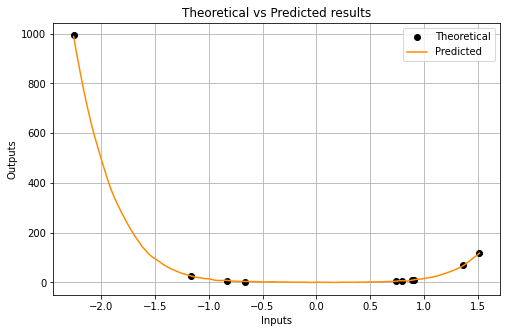

In [ ]:
for x,y in test_dl:

  x1 = x.flatten().numpy()
  y1 = (np.array([((i* std_y) + mean_y) for i in y.flatten().numpy()]))

  order = np.argsort(x1)

  xs = x1[order]
  ys = y1[order]

  min_x = min(x1)
  max_x = max(x1)

  c = ((torch.from_numpy(np.linspace(min_x, max_x, 10000))).view(10000,1)).to(dtype = torch.float32)

  #moving model back to CPU for testing

  device = torch.device('cpu')
  model_cpu = model.to(device)
  p = model_cpu(c)
  preds_unnorm = np.array([((i* std_y) + mean_y) for i in p.flatten().detach().numpy()])

  #print(preds_unnorm)

  #print(y1)
  #print(preds_unnorm)
  plt.figure(figsize = (8,5))
  plt.plot(xs, ys, '.', color = 'black', markersize = 12, label = 'Theoretical')
  plt.plot(c.flatten().numpy(), preds_unnorm, color = 'darkorange', label = 'Predicted')
  plt.title('Theoretical vs Predicted results')
  plt.xlabel('Inputs')
  plt.ylabel('Outputs')
  plt.grid()
  plt.legend()
  plt.show() 
  #print(c)
  
  break




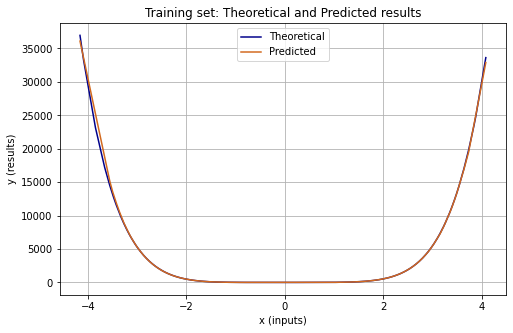

Testing loss: 0.0006897347630001605


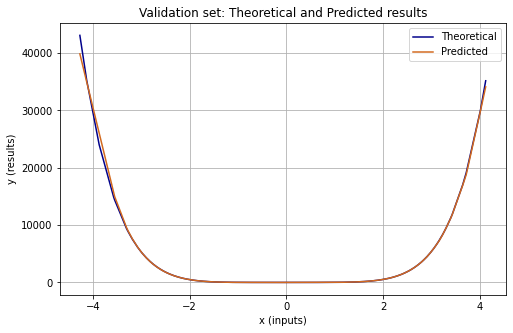

Testing loss: 0.0026396866887807846


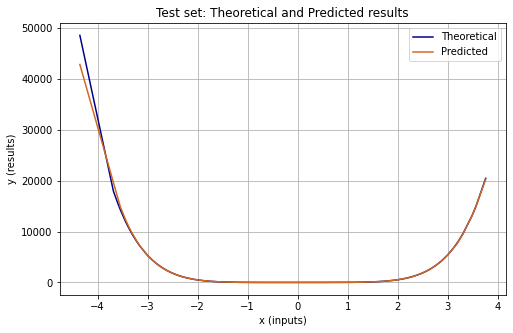

Testing loss: 0.006264179013669491


In [ ]:
sample_train = SubsetRandomSampler(train_idx)
#forming the training DataLoader
train_dl_plot = DataLoader(data_set, batch_size = len(train_idx), sampler = sample_train)

sample_val = SubsetRandomSampler(val_idx)
#forming the training DataLoader
valid_dl_plot = DataLoader(data_set, batch_size = len(val_idx), sampler = sample_val)

sample_test = SubsetRandomSampler(test_idx)
#forming the training DataLoader
test_dl_plot = DataLoader(data_set, batch_size = len(test_idx), sampler = sample_test)


for x,y in train_dl_plot:

  x1 = x.flatten().numpy()
  y1 = (np.array([((i* std_y) + mean_y) for i in y.flatten().numpy()]))

  order = np.argsort(x1)

  xs = x1[order]
  ys = y1[order]

  device = torch.device('cpu')
  model_cpu = model.to(device)
  p = model_cpu(x)

  preds_unnorm = np.array([((i* std_y) + mean_y) for i in p.flatten().detach().numpy()])
  yp = preds_unnorm[order]

  plt.figure(figsize = (8,5))
  plt.plot(xs, ys, color = 'darkblue', label = 'Theoretical')
  plt.plot(xs, yp, color = 'chocolate', label = 'Predicted')
  plt.title('Training set: Theoretical and Predicted results')
  plt.ylabel('y (results)')
  plt.xlabel('x (inputs)')
  plt.grid()
  plt.legend()
  plt.show()

train_loss,_ = evaluate(model, F.mse_loss, train_dl_plot)
print('Training loss:', train_loss)


for x,y in valid_dl_plot:

  x1 = x.flatten().numpy()
  y1 = (np.array([((i* std_y) + mean_y) for i in y.flatten().numpy()]))

  order = np.argsort(x1)

  xs = x1[order]
  ys = y1[order]

  device = torch.device('cpu')
  model_cpu = model.to(device)
  p = model_cpu(x)

  preds_unnorm = np.array([((i* std_y) + mean_y) for i in p.flatten().detach().numpy()])
  yp = preds_unnorm[order]

  plt.figure(figsize = (8,5))
  plt.plot(xs, ys, color = 'darkblue', label = 'Theoretical')
  plt.plot(xs, yp, color = 'chocolate', label = 'Predicted')
  plt.title('Validation set: Theoretical and Predicted results')
  plt.ylabel('y (results)')
  plt.xlabel('x (inputs)')
  plt.grid()
  plt.legend()
  plt.show()


val_loss,_ = evaluate(model, F.mse_loss, valid_dl_plot)
print('Validation loss:', val_loss)

for x,y in test_dl_plot:

  x1 = x.flatten().numpy()
  y1 = (np.array([((i* std_y) + mean_y) for i in y.flatten().numpy()]))

  order = np.argsort(x1)

  xs = x1[order]
  ys = y1[order]

  device = torch.device('cpu')
  model_cpu = model.to(device)
  p = model_cpu(x)

  preds_unnorm = np.array([((i* std_y) + mean_y) for i in p.flatten().detach().numpy()])
  yp = preds_unnorm[order]

  plt.figure(figsize = (8,5))
  plt.plot(xs, ys, color = 'darkblue', label = 'Theoretical')
  plt.plot(xs, yp, color = 'chocolate', label = 'Predicted')
  plt.title('Test set: Theoretical and Predicted results')
  plt.ylabel('y (results)')
  plt.xlabel('x (inputs)')
  plt.grid()
  plt.legend()
  plt.show()


test_loss,_ = evaluate(model, F.mse_loss, test_dl_plot)
print('Testing loss:', test_loss)
